<a href="https://colab.research.google.com/github/PALLAVI-web2002/predicting-coffee-sales-ml/blob/main/Fraud_Detection_System_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries imported successfully
Generating transaction data...
Dataset shape: (100000, 32)
Fraud rate: 0.5000%
Fraud distribution:
is_fraud
0    99500
1      500
Name: count, dtype: int64

Performing exploratory data analysis...


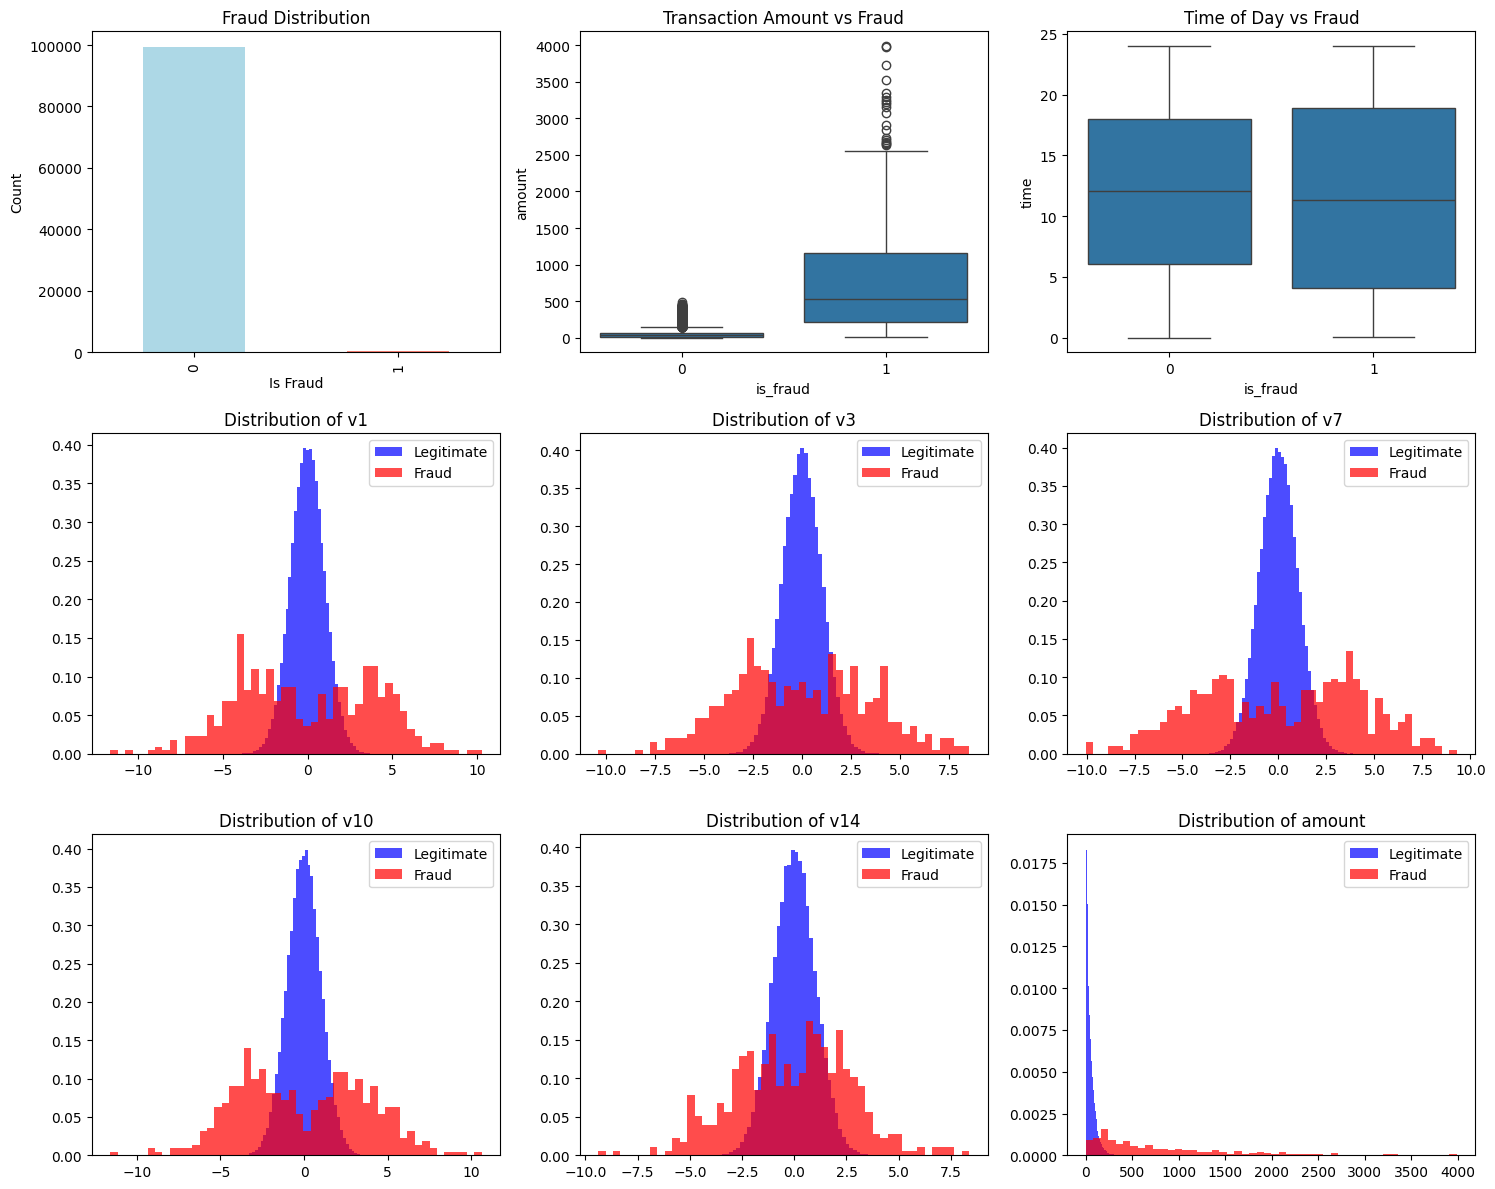

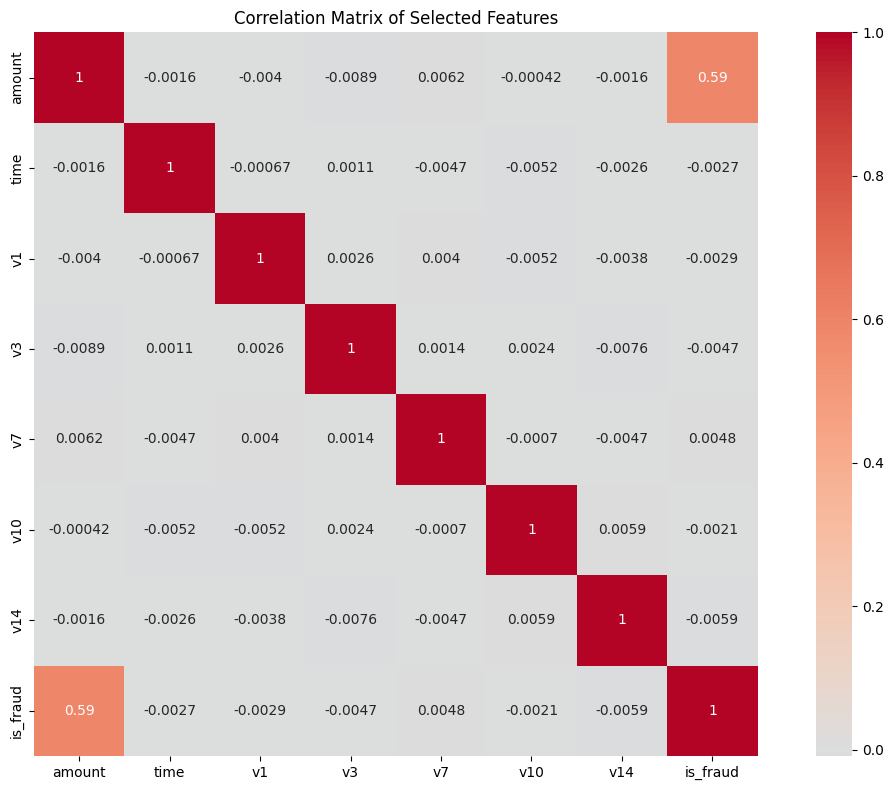


Preprocessing data...
Feature matrix shape: (100000, 30)
Target distribution: {0: 99500, 1: 500}
Training set size: (80000, 30)
Test set size: (20000, 30)
Training fraud rate: 0.5000%

Handling class imbalance...
Before SMOTE - Fraud cases: 400
After SMOTE - Fraud cases: 79600

Training Anomaly Detection Models...
Training Isolation Forest...
Completed Isolation Forest: F1=0.5900, Precision=0.5900, Recall=0.5900
Training Local Outlier Factor...
Completed Local Outlier Factor: F1=0.4532, Precision=0.4466, Recall=0.4600

Training Classification Models...
Training Logistic Regression...
Completed Logistic Regression: F1=0.1375, Precision=0.0743, Recall=0.9200
Training Random Forest...
Completed Random Forest: F1=0.9538, Precision=0.9789, Recall=0.9300
Training XGBoost...
Completed XGBoost: F1=0.9474, Precision=0.9083, Recall=0.9900

Training Neural Network Autoencoder...
Autoencoder completed: F1=0.5294, Precision=1.0000, Recall=0.3600

Model Performance Comparison:
                  Mod

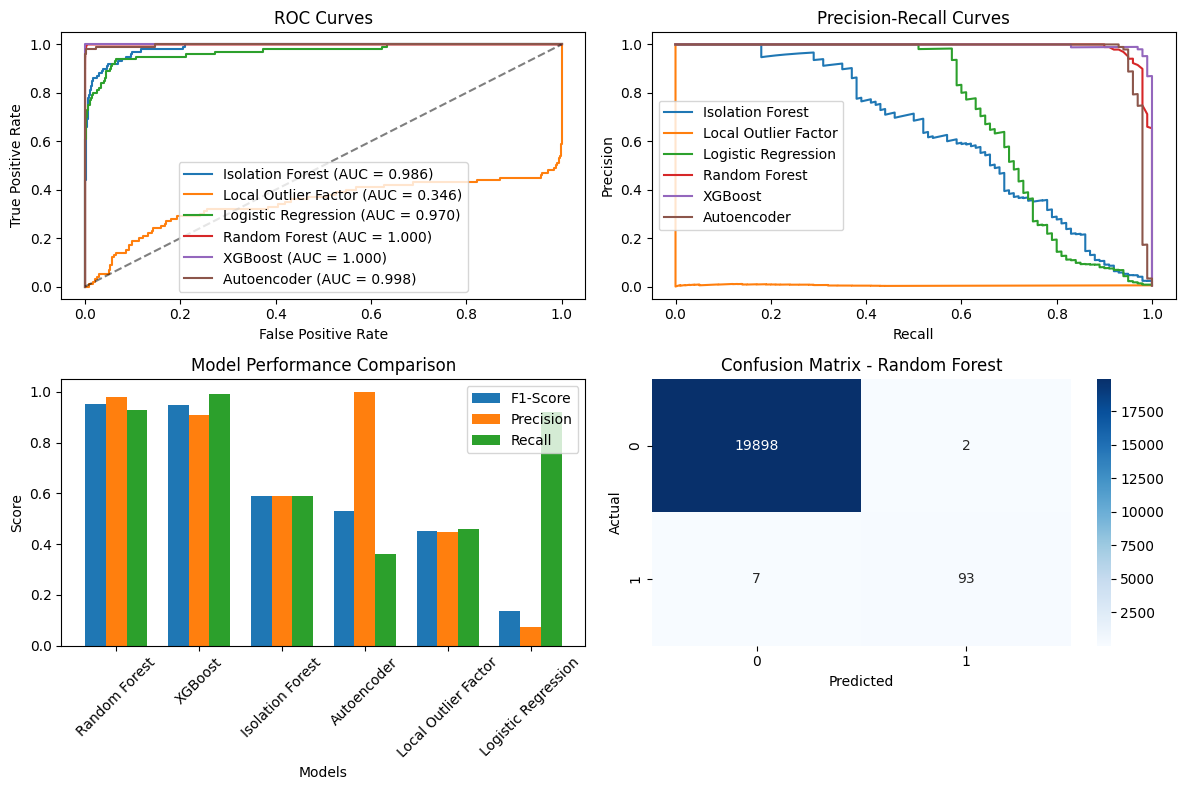


Best Model: Random Forest
F1-Score: 0.9538
Precision: 0.9789
Recall: 0.9300
ROC-AUC: 0.9999

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19900
           1       0.98      0.93      0.95       100

    accuracy                           1.00     20000
   macro avg       0.99      0.96      0.98     20000
weighted avg       1.00      1.00      1.00     20000


Top Fraud Indicators:
   feature  importance
0   amount      0.4123
8       v7      0.1681
2       v1      0.1584
11     v10      0.0941
4       v3      0.0668
15     v14      0.0382
6       v5      0.0068
13     v12      0.0040
9       v8      0.0037
29     v28      0.0036

Fraud Pattern Analysis:
Average transaction amount - Fraud: $812.56
Average transaction amount - Legitimate: $49.31
Average time - Fraud: 11.8h
Average time - Legitimate: 12.0h

Testing prediction on sample transaction:
fraud_probability: 0.48
is_fraud: 0
risk_level: Me

In [ ]:
# Fraud Detection System using Machine Learning
# Anomaly Detection and Classification Approaches

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             roc_curve, f1_score, precision_score,
                             recall_score, average_precision_score)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

# 1. Data Generation and Loading
def generate_fraud_data(n_samples=100000):
    """Generate realistic credit card transaction data with fraud patterns"""
    np.random.seed(42)

    data = {
        'transaction_id': [f'TXN_{i:08d}' for i in range(n_samples)],
        'amount': np.round(np.random.exponential(50, n_samples), 2),
        'time': np.random.uniform(0, 24, n_samples),
        'v1': np.random.normal(0, 1, n_samples),
        'v2': np.random.normal(0, 1, n_samples),
        'v3': np.random.normal(0, 1, n_samples),
        'v4': np.random.normal(0, 1, n_samples),
        'v5': np.random.normal(0, 1, n_samples),
        'v6': np.random.normal(0, 1, n_samples),
        'v7': np.random.normal(0, 1, n_samples),
        'v8': np.random.normal(0, 1, n_samples),
        'v9': np.random.normal(0, 1, n_samples),
        'v10': np.random.normal(0, 1, n_samples),
        'v11': np.random.normal(0, 1, n_samples),
        'v12': np.random.normal(0, 1, n_samples),
        'v13': np.random.normal(0, 1, n_samples),
        'v14': np.random.normal(0, 1, n_samples),
        'v15': np.random.normal(0, 1, n_samples),
        'v16': np.random.normal(0, 1, n_samples),
        'v17': np.random.normal(0, 1, n_samples),
        'v18': np.random.normal(0, 1, n_samples),
        'v19': np.random.normal(0, 1, n_samples),
        'v20': np.random.normal(0, 1, n_samples),
        'v21': np.random.normal(0, 1, n_samples),
        'v22': np.random.normal(0, 1, n_samples),
        'v23': np.random.normal(0, 1, n_samples),
        'v24': np.random.normal(0, 1, n_samples),
        'v25': np.random.normal(0, 1, n_samples),
        'v26': np.random.normal(0, 1, n_samples),
        'v27': np.random.normal(0, 1, n_samples),
        'v28': np.random.normal(0, 1, n_samples),
    }

    df = pd.DataFrame(data)

    # Create fraud probability based on realistic patterns
    fraud_proba = np.zeros(n_samples)

    for i in range(n_samples):
        fraud_score = (
            -4.0 +
            0.02 * df.loc[i, 'amount'] +
            0.5 * abs(df.loc[i, 'time'] - 12) / 6 +
            2.0 * abs(df.loc[i, 'v1']) +
            1.5 * abs(df.loc[i, 'v3']) +
            2.0 * abs(df.loc[i, 'v7']) +
            1.8 * abs(df.loc[i, 'v10']) +
            0.8 * abs(df.loc[i, 'v14']) +
            np.random.logistic(0, 1)
        )
        fraud_proba[i] = 1 / (1 + np.exp(-fraud_score))

    fraud_threshold = np.percentile(fraud_proba, 99.5)
    df['is_fraud'] = (fraud_proba > fraud_threshold).astype(int)

    # Enhance fraud patterns
    fraud_indices = df[df['is_fraud'] == 1].index
    df.loc[fraud_indices, 'amount'] = df.loc[fraud_indices, 'amount'] * np.random.uniform(2, 10, len(fraud_indices))

    for col in ['v1', 'v3', 'v7', 'v10', 'v14']:
        df.loc[fraud_indices, col] = df.loc[fraud_indices, col] * np.random.uniform(1.5, 3, len(fraud_indices))

    return df

print("Generating transaction data...")
df = generate_fraud_data(100000)

print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean():.4%}")
print(f"Fraud distribution:\n{df['is_fraud'].value_counts()}")

# 2. Exploratory Data Analysis
print("\nPerforming exploratory data analysis...")

plt.figure(figsize=(15, 12))

# Fraud distribution
plt.subplot(3, 3, 1)
df['is_fraud'].value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Fraud Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')

# Amount vs Fraud
plt.subplot(3, 3, 2)
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.title('Transaction Amount vs Fraud')

# Time vs Fraud
plt.subplot(3, 3, 3)
sns.boxplot(x='is_fraud', y='time', data=df)
plt.title('Time of Day vs Fraud')

# Feature distributions
features_to_plot = ['v1', 'v3', 'v7', 'v10', 'v14', 'amount']
for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+4)
    plt.hist(df[df['is_fraud'] == 0][feature], bins=50, alpha=0.7, label='Legitimate', color='blue', density=True)
    plt.hist(df[df['is_fraud'] == 1][feature], bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 8))
selected_features = ['amount', 'time', 'v1', 'v3', 'v7', 'v10', 'v14', 'is_fraud']
correlation_matrix = df[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

# 3. Data Preprocessing
print("\nPreprocessing data...")

df_processed = df.copy()
df_processed = df_processed.drop('transaction_id', axis=1)

X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4%}")

# Preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Apply preprocessor to training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# 4. Handle Class Imbalance with SMOTE
print("\nHandling class imbalance...")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Before SMOTE - Fraud cases: {y_train.sum()}")
print(f"After SMOTE - Fraud cases: {y_resampled.sum()}")

# 5. Anomaly Detection Models
print("\nTraining Anomaly Detection Models...")

anomaly_models = {
    'Isolation Forest': IsolationForest(contamination=0.005, random_state=42, n_estimators=100),
    'Local Outlier Factor': LocalOutlierFactor(contamination=0.005, novelty=True),
}

anomaly_results = {}

for name, model in anomaly_models.items():
    print(f"Training {name}...")

    model.fit(X_train_processed)
    y_pred_anomaly = model.predict(X_test_processed)
    y_pred_binary = (y_pred_anomaly == -1).astype(int)

    if hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test_processed)
        if name == 'Isolation Forest':
            y_scores = -y_scores
    else:
        y_scores = model.score_samples(X_test_processed)
        y_scores = -y_scores

    f1 = f1_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_scores)

    anomaly_results[name] = {
        'model': model,
        'y_pred': y_pred_binary,
        'y_scores': y_scores,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

    print(f"Completed {name}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# 6. Classification Models
print("\nTraining Classification Models...")

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])),
}

classification_results = {}

for name, model in classification_models.items():
    print(f"Training {name}...")

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train_processed, y_train)
    y_pred = pipeline.predict(X_test_processed)
    y_pred_proba = pipeline.predict_proba(X_test_processed)[:, 1]

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    classification_results[name] = {
        'model': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'average_precision': avg_precision
    }

    print(f"Completed {name}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# 7. Neural Network Autoencoder
print("\nTraining Neural Network Autoencoder...")

class FraudAutoencoder:
    def __init__(self, input_dim, encoding_dim=14):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.model = self._build_model()

    def _build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(32, activation="relu",
                       activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dropout(0.2)(encoder)
        encoder = Dense(16, activation="relu")(encoder)
        encoder = Dense(self.encoding_dim, activation="relu")(encoder)

        decoder = Dense(16, activation="relu")(encoder)
        decoder = Dropout(0.2)(decoder)
        decoder = Dense(32, activation="relu")(decoder)
        decoder = Dense(self.input_dim, activation='linear')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

    def fit(self, X, epochs=50, batch_size=32, validation_split=0.1):
        self.history = self.model.fit(
            X, X,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            shuffle=True,
            verbose=0
        )
        return self.history

    def predict(self, X):
        reconstructions = self.model.predict(X, verbose=0)
        mse = np.mean(np.power(X - reconstructions, 2), axis=1)
        return mse

# Prepare data for autoencoder
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train on legitimate transactions only
X_train_legit = X_train_scaled[y_train == 0]

autoencoder = FraudAutoencoder(input_dim=X_train_scaled.shape[1])
history = autoencoder.fit(X_train_legit, epochs=50, batch_size=32)

# Calculate reconstruction error
test_scores = autoencoder.predict(X_test_scaled)
test_scores_normalized = (test_scores - np.min(test_scores)) / (np.max(test_scores) - np.min(test_scores))

# Find optimal threshold
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []
for threshold in thresholds:
    y_pred_autoencoder = (test_scores_normalized > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_autoencoder))

best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_autoencoder = (test_scores_normalized > best_threshold).astype(int)

# Calculate metrics
f1_ae = f1_score(y_test, y_pred_autoencoder)
precision_ae = precision_score(y_test, y_pred_autoencoder)
recall_ae = recall_score(y_test, y_pred_autoencoder)
roc_auc_ae = roc_auc_score(y_test, test_scores_normalized)

classification_results['Autoencoder'] = {
    'model': autoencoder,
    'y_pred': y_pred_autoencoder,
    'y_pred_proba': test_scores_normalized,
    'f1_score': f1_ae,
    'precision': precision_ae,
    'recall': recall_ae,
    'roc_auc': roc_auc_ae
}

print(f"Autoencoder completed: F1={f1_ae:.4f}, Precision={precision_ae:.4f}, Recall={recall_ae:.4f}")

# 8. Model Comparison
print("\nModel Performance Comparison:")

all_results = {**anomaly_results, **classification_results}

comparison_data = []
for name, results in all_results.items():
    comparison_data.append({
        'Model': name,
        'F1-Score': results['f1_score'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'ROC-AUC': results['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('F1-Score', ascending=False)
print(comparison_df.round(4))

# Visualization
plt.figure(figsize=(12, 8))

# ROC Curves
plt.subplot(2, 2, 1)
for name, result in all_results.items():
    fpr, tpr, _ = roc_curve(y_test, result.get('y_pred_proba', result.get('y_scores', np.zeros_like(y_test))))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Precision-Recall Curves
plt.subplot(2, 2, 2)
for name, result in all_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result.get('y_pred_proba', result.get('y_scores', np.zeros_like(y_test))))
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()

# Performance comparison
plt.subplot(2, 2, 3)
metrics = ['F1-Score', 'Precision', 'Recall']
x_pos = np.arange(len(comparison_df))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x_pos + i*width, comparison_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos + width, comparison_df['Model'], rotation=45)
plt.legend()

# Confusion Matrix for best model
plt.subplot(2, 2, 4)
best_model_name = comparison_df.iloc[0]['Model']
best_result = all_results[best_model_name]
cm = confusion_matrix(y_test, best_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 9. Best Model Analysis
print(f"\nBest Model: {best_model_name}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"ROC-AUC: {best_result['roc_auc']:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, best_result['y_pred']))

# 10. Feature Importance Analysis
if best_model_name in ['Random Forest', 'XGBoost']:
    print("\nTop Fraud Indicators:")

    if hasattr(best_result['model'], 'feature_importances_'):
        feature_importance = best_result['model'].feature_importances_
    else:
        feature_importance = best_result['model'].named_steps['classifier'].feature_importances_

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(10)

    print(importance_df.round(4))

# 11. Business Insights
print("\nFraud Pattern Analysis:")
fraud_cases = X_test[y_test == 1]
legitimate_cases = X_test[y_test == 0]

print(f"Average transaction amount - Fraud: ${fraud_cases['amount'].mean():.2f}")
print(f"Average transaction amount - Legitimate: ${legitimate_cases['amount'].mean():.2f}")
print(f"Average time - Fraud: {fraud_cases['time'].mean():.1f}h")
print(f"Average time - Legitimate: {legitimate_cases['time'].mean():.1f}h")

# 12. Model Deployment Preparation
def predict_fraud_single(transaction_data, model, preprocessor, model_type='classification'):
    """Predict fraud probability for a single transaction"""
    transaction_df = pd.DataFrame([transaction_data])

    if model_type == 'autoencoder':
        transaction_scaled = preprocessor.transform(transaction_df)
        fraud_score = model.predict(transaction_scaled)[0]
        fraud_probability = (fraud_score - np.min(fraud_score)) / (np.max(fraud_score) - np.min(fraud_score))
    else:
        # Apply preprocessing before predicting
        transaction_processed = preprocessor.transform(transaction_df)
        fraud_probability = model.predict_proba(transaction_processed)[0, 1]


    return {
        'fraud_probability': float(fraud_probability),
        'is_fraud': int(fraud_probability > 0.5),
        'risk_level': 'High' if fraud_probability > 0.7 else 'Medium' if fraud_probability > 0.3 else 'Low'
    }

# Test prediction
sample_transaction = {
    'amount': 150.0,
    'time': 2.5,
    'v1': 2.1,
    'v2': -1.3,
    'v3': 1.8,
    'v4': -0.5,
    'v5': 0.8,
    'v6': -1.2,
    'v7': 2.5,
    'v8': -0.9,
    'v9': 1.1,
    'v10': 2.2,
    'v11': -1.0,
    'v12': 0.7,
    'v13': -0.8,
    'v14': 1.9,
    'v15': -0.6,
    'v16': 0.9,
    'v17': -1.1,
    'v18': 0.8,
    'v19': -0.7,
    'v20': 1.2,
    'v21': -0.9,
    'v22': 0.6,
    'v23': -0.8,
    'v24': 1.0,
    'v25': -0.5,
    'v26': 0.7,
    'v27': -0.6,
    'v28': 0.8
}

print("\nTesting prediction on sample transaction:")
# Pass the original preprocessor and specify model type
prediction = predict_fraud_single(sample_transaction, best_result['model'], preprocessor, model_type='classification')
for key, value in prediction.items():
    print(f"{key}: {value}")

print("\nFraud detection system implementation completed successfully.")